In [1]:
import tensorflow as tf
import keras
import cv2
import os
import PIL
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import pathlib
from keras.models import Sequential
from keras.layers import Dropout,Flatten,Dense,Conv2D,MaxPooling2D,BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow_hub as hub

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
dataset_dir=r'/kaggle/input/eye-diseases-classification/dataset'
dataset_dir

'/kaggle/input/eye-diseases-classification/dataset'

In [3]:
#we are going to all eye images one by one and read them into numpy array.for this,pathlib will be usefil
dataset_dir=pathlib.Path(dataset_dir)
dataset_dir

PosixPath('/kaggle/input/eye-diseases-classification/dataset')

In [4]:
cataract=len(list(dataset_dir.glob('cataract/*')))
print("total number of cataract:",cataract)
diabetic_retinopathy=len(list(dataset_dir.glob('diabetic_retinopathy/*')))
print("total number of diabetic_retinopathy:",diabetic_retinopathy)
glaucoma=len(list(dataset_dir.glob('glaucoma/*')))
print("total number of glaucoma:",glaucoma)
normal=len(list(dataset_dir.glob('normal/*')))
print("total number of normal:",normal)
#total=4217

total number of cataract: 1038
total number of diabetic_retinopathy: 1098
total number of glaucoma: 1007
total number of normal: 1074


In [5]:
#create a dictionary which has all the image path
eyes_image_dict={
    'cataract':list(dataset_dir.glob('cataract/*')),
    'diabetic_retinopathy':list(dataset_dir.glob('diabetic_retinopathy/*')),
    'glaucoma':list(dataset_dir.glob('glaucoma/*')),
    'normal':list(dataset_dir.glob('normal/*')),
}

In [6]:
#assigning a class number to each of these eyes images  randomly
eyes_labels_dict={
    'cataract':0,
    'diabetic_retinopathy':1,
    'glaucoma':2,
    'normal':3
}

In [7]:
img=cv2.imread(str(eyes_image_dict['cataract'][0]))
img.shape

(256, 256, 3)

**Read the image and convert it into 3 dimentional numpy array and resize it** 

In [8]:
x, y = [], []

for eye_name, images in eyes_image_dict.items():
    for image in images:
        img = cv2.imread(str(image))#opencv read the images and convert it into 3 dimensional numpy array
        resized_img = cv2.resize(img,(224,224))#resize it cause ML wants all training samples should be the same size
        x.append(resized_img)
        y.append(eyes_labels_dict[eye_name])


In [9]:
cataract=list(dataset_dir.glob('cataract/*'))
diabetic_retinopathy=list(dataset_dir.glob('diabetic_retinopathy/*'))
glaucoma=list(dataset_dir.glob('glaucoma/*'))
normal=list(dataset_dir.glob('normal/*'))


**Display some of the images**

In [10]:
r1=io.imread(str(cataract[0]))
r2=io.imread(str(diabetic_retinopathy[0]))
r3=io.imread(str(glaucoma[0]))
r4=io.imread(str(normal[0]))

(-0.5, 511.5, 511.5, -0.5)

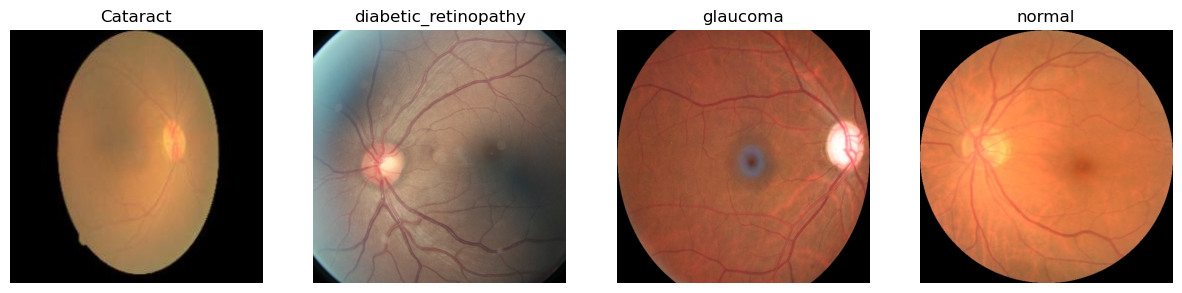

In [11]:
fig=plt.figure(figsize=(15,20))
plt.subplot(1,4,1) 
plt.imshow(r1)
plt.title("Cataract")
plt.axis("off")

plt.subplot(1,4,2) 
plt.imshow(r2)
plt.title("diabetic_retinopathy")
plt.axis("off")

plt.subplot(1,4,3) 
plt.imshow(r3)
plt.title("glaucoma")
plt.axis("off")

plt.subplot(1,4,4) 
plt.imshow(r4)
plt.title("normal")
plt.axis("off")

In [12]:
x=np.array(x)
y=np.array(y)

**Train-Test Split**

In [13]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=.2)

In [14]:
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')


**Scaling/Normalization**

In [15]:
x_train_scaled=x_train/255
x_test_scaled=x_test/255

In [16]:
input_shape=(224,224,3)

In [17]:
data_augmentation = keras.Sequential([
  #types of transformation applied here
    layers.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.3)

])

**Build a CNN model**

In [18]:
num_classes=4
model=Sequential()
model.add(data_augmentation)
model.add(Conv2D(16,kernel_size=(3,3),
                 padding='same',
                 activation='relu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,(3,3),
                padding='same',
                activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),
                padding='same',
                activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),
                padding='same',
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

#if y is hotencoded,then we use categorical crossentrophy otherwise SparseCategoricalCrossentropy
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])



**train the model**

In [19]:
epochs=50
history=model.fit(x_train_scaled,
          y_train,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_scaled,y_test))
score=model.evaluate(x_test_scaled,y_test,verbose=0)
print("Test loss:",score[0])
print("Test accuracy:",score[1])

Epoch 1/50
106/106 [==============================] - 17s 64ms/step - loss: 1.3180 - accuracy: 0.4699 - val_loss: 2.3492 - val_accuracy: 0.2571
Epoch 2/50
106/106 [==============================] - 5s 46ms/step - loss: 0.9978 - accuracy: 0.5929 - val_loss: 1.6483 - val_accuracy: 0.3365
Epoch 3/50
106/106 [==============================] - 5s 47ms/step - loss: 0.8606 - accuracy: 0.6588 - val_loss: 1.5553 - val_accuracy: 0.4419
Epoch 4/50
106/106 [==============================] - 5s 46ms/step - loss: 0.7221 - accuracy: 0.7065 - val_loss: 0.8168 - val_accuracy: 0.6671
Epoch 5/50
106/106 [==============================] - 5s 46ms/step - loss: 0.6544 - accuracy: 0.7438 - val_loss: 0.7097 - val_accuracy: 0.7002
Epoch 6/50
106/106 [==============================] - 5s 47ms/step - loss: 0.5907 - accuracy: 0.7664 - val_loss: 0.6286 - val_accuracy: 0.7275
Epoch 7/50
106/106 [==============================] - 5s 46ms/step - loss: 0.5757 - accuracy: 0.7744 - val_loss: 1.0373 - val_accuracy: 0.555

**save the model**

In [20]:
model.save("F:\Learning Course")

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)    

**Load the model**

**plotting train vs test accuracy**

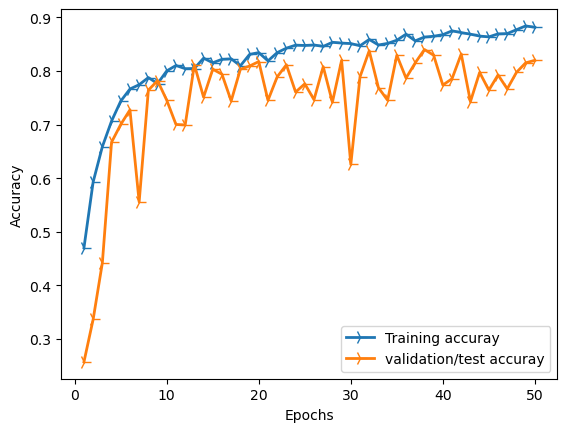

In [22]:

history_dict=history.history

acc_values=history_dict['accuracy']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,len(acc_values)+1)

line1=plt.plot(epochs,acc_values,label='Training accuray')
line2=plt.plot(epochs,val_acc_values,label='validation/test accuray')

plt.setp(line1,linewidth=2.0,marker='4',markersize='10.0')
plt.setp(line2,linewidth=2.0,marker='4',markersize='10.0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

**plotting train vs test loss**

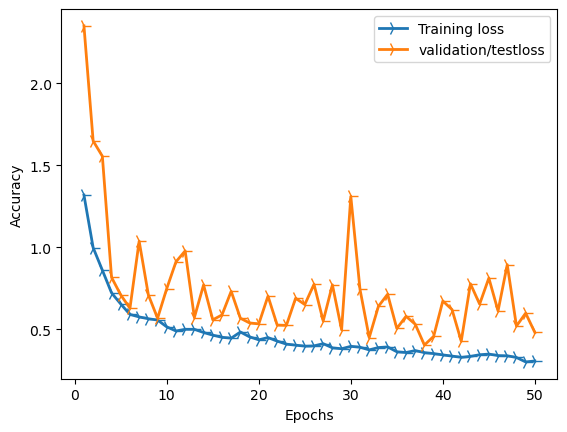

In [23]:

history_dict=history.history

loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)

line1=plt.plot(epochs,loss_values,label='Training loss')
line2=plt.plot(epochs,val_loss_values,label='validation/testloss')

plt.setp(line1,linewidth=2.0,marker='4',markersize='10.0')
plt.setp(line2,linewidth=2.0,marker='4',markersize='10.0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

**Classification report and confusion matrix**

27/27 [==============================] - 1s 16ms/step


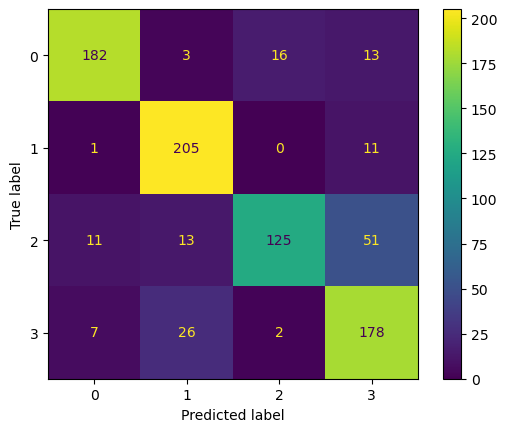

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       214
           1       0.83      0.94      0.88       217
           2       0.87      0.62      0.73       200
           3       0.70      0.84      0.76       213

    accuracy                           0.82       844
   macro avg       0.83      0.81      0.81       844
weighted avg       0.83      0.82      0.82       844



In [24]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred=model.predict(x_test_scaled).round()
y_pred = np.argmax(y_pred,axis=1)
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test,y_pred))



# Transfer learning-EfficientNet B0

In [25]:
#include all of the layers except the last layer
feature_extractor_model = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)
#trainable=False means freeze the layers ,we do not train

In [26]:
num_of_eyes = 4

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,# previous layers are already trained
  tf.keras.layers.Dense(num_of_eyes)# last layer is only mine
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,054,688
Trainable params: 5,124
Non-trainable params: 4,049,564
_________________________________________________________________


In [27]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train_scaled,
          y_train,
          epochs=50,
          verbose=1,
          validation_data=(x_test_scaled,y_test))
score=model.evaluate(x_test_scaled,y_test,verbose=0)

Epoch 1/50
106/106 [==============================] - 21s 102ms/step - loss: 0.7434 - accuracy: 0.7364 - val_loss: 0.5174 - val_accuracy: 0.8211
Epoch 2/50
106/106 [==============================] - 7s 70ms/step - loss: 0.4937 - accuracy: 0.8272 - val_loss: 0.4296 - val_accuracy: 0.8483
Epoch 3/50
106/106 [==============================] - 7s 71ms/step - loss: 0.4268 - accuracy: 0.8524 - val_loss: 0.3968 - val_accuracy: 0.8543
Epoch 4/50
106/106 [==============================] - 7s 71ms/step - loss: 0.3891 - accuracy: 0.8669 - val_loss: 0.3668 - val_accuracy: 0.8744
Epoch 5/50
106/106 [==============================] - 8s 71ms/step - loss: 0.3646 - accuracy: 0.8776 - val_loss: 0.3564 - val_accuracy: 0.8744
Epoch 6/50
106/106 [==============================] - 7s 71ms/step - loss: 0.3418 - accuracy: 0.8879 - val_loss: 0.3526 - val_accuracy: 0.8673
Epoch 7/50
106/106 [==============================] - 7s 71ms/step - loss: 0.3303 - accuracy: 0.8891 - val_loss: 0.3386 - val_accuracy: 0.87

27/27 [==============================] - 2s 55ms/step


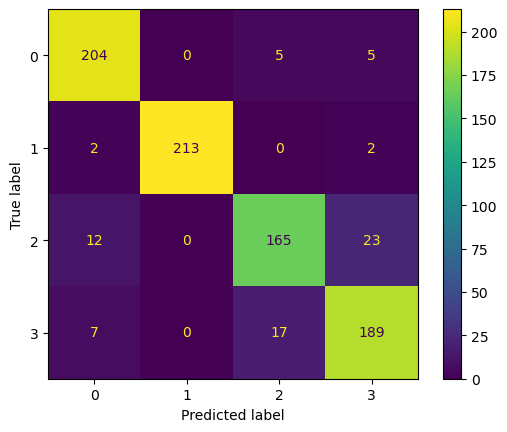

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       214
           1       1.00      0.98      0.99       217
           2       0.88      0.82      0.85       200
           3       0.86      0.89      0.88       213

    accuracy                           0.91       844
   macro avg       0.91      0.91      0.91       844
weighted avg       0.91      0.91      0.91       844



In [28]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred=model.predict(x_test_scaled).round()
y_pred = np.argmax(y_pred,axis=1)
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test,y_pred))
